In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

import os
import cv2

2024-10-11 15:17:29.004381: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 15:17:29.088665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 15:17:29.142506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 15:17:29.155173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 15:17:29.223366: I tensorflow/core/platform/cpu_feature_guar

<h2>Model</h2>

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2

# Load the pre-trained Mask R-CNN model from TensorFlow Hub
mask_rcnn_model = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1")

def segment_objects(image):
    """
    Uses a pre-trained Mask R-CNN model to segment objects in the stack.
    
    Args:
    - image: np.array, the input image of the stack.
    
    Returns:
    - segmented_image: np.array, the image with separated objects.
    """
    # Convert the image to a tensor
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]  # Add batch dimension
    
    # Run the image through the Mask R-CNN model to get detection results
    detections = mask_rcnn_model(input_tensor)
    
    # Get the detection scores, boxes, and masks
    detection_scores = detections['detection_scores'][0].numpy()
    detection_boxes = detections['detection_boxes'][0].numpy()
    detection_classes = detections['detection_classes'][0].numpy().astype(np.int32)
    detection_masks = detections['detection_masks'][0].numpy()
    
    # Filter the objects (we can assume blocks in the stack are among the detected objects)
    height, width, _ = image.shape
    segmented_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    for i in range(detection_scores.shape[0]):
        # Only consider objects with a high detection score (confidence)
        if detection_scores[i] >= 0.5:
            # Get the bounding box and mask for the object
            box = detection_boxes[i]
            mask = detection_masks[i]
            
            # Convert the bounding box from relative coordinates to absolute pixel coordinates
            ymin, xmin, ymax, xmax = box
            ymin = int(ymin * height)
            xmin = int(xmin * width)
            ymax = int(ymax * height)
            xmax = int(xmax * width)
            
            # Resize the mask to match the original image dimensions
            mask_resized = cv2.resize(mask, (xmax - xmin, ymax - ymin))
            mask_resized = (mask_resized > 0.5).astype(np.uint8)  # Binarize mask
            
            # Apply the mask to the detected region in the segmented image
            segmented_image[ymin:ymax, xmin:xmax] = np.where(mask_resized[:, :, np.newaxis], image[ymin:ymax, xmin:xmax], segmented_image[ymin:ymax, xmin:xmax])
    
    return segmented_image


In [3]:
def preprocess_image(image):
    """
    Preprocesses the image by first segmenting objects and then resizing.
    
    Args:
    - image: np.array, the input image of the stack.
    
    Returns:
    - preprocessed_image: np.array, the preprocessed image.
    """
    # Apply segmentation first
    segmented_image = segment_objects(image)
    
    # Resize the segmented image to the input size expected by EfficientNet
    preprocessed_image = cv2.resize(segmented_image, (224, 224))
    
    # Normalize the image to [0, 1]
    preprocessed_image = preprocessed_image / 255.0
    
    return preprocessed_image

In [13]:
img = preprocess_image(cv2.imread('../COMP90086_2024_Project_train/train/54.jpg'))

KeyError: 'detection_masks'

In [4]:
def get_model(image_input_shape):
    """
    Creates a model that takes only image input to predict stable height, considering class imbalance and overfitting prevention.
    
    Args:
    - image_input_shape: tuple, the shape of the input image (e.g., (224, 224, 3))
    
    Returns:
    - model: Keras model object
    """
    
    # IMAGE INPUT BRANCH
    image_input = Input(shape=image_input_shape, name='image_input')
    
    # Use EfficientNetB0 as a pre-trained model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=image_input_shape)
    
    # Fine-tuning: Unfreeze the last few layers of the base model to allow some training
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    # Extract features from the image
    x = base_model(image_input)
    x = Flatten()(x)
    
    # Add fully connected layers with L2 regularization to prevent overfitting
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    
    # Final output layer (regression output for stable height)
    output = Dense(1, activation='linear', name='output')(x)
    
    # Build the final model
    model = Model(inputs=image_input, outputs=output)
    
    # Define class weights based on the observed distribution
    class_weights = tf.constant([1.5, 1.5, 1.2, 1.0, 0.8, 0.5], dtype=tf.float32)  # Adjust weights as needed

    # Custom weighted loss function
    def weighted_loss(y_true, y_pred):
        # Ensure that labels are properly cast and indexed correctly
        y_true_int = tf.cast(y_true, tf.int32)
        y_true_int = tf.clip_by_value(y_true_int - 1, 0, len(class_weights) - 1)  # Subtract 1 to match index
        
        # Get the corresponding class weight
        class_weight = tf.gather(class_weights, y_true_int)
        
        # Cast y_true to float32 to match y_pred
        y_true_float = tf.cast(y_true, tf.float32)
        
        # Compute the weighted mean squared error
        loss = class_weight * tf.square(y_true_float - y_pred)
        return tf.reduce_mean(loss)
    
    # Compile the model with a custom weighted loss function and Adam optimizer with a smaller learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=weighted_loss, metrics=['mae'])
    
    return model

In [5]:
def load_images_from_folder(folder_path, ids, image_size=(224, 224)):
    images = []
    for id in ids:
        filename = str(int(id)) + '.jpg'

        # Load the image using OpenCV
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        # Resize the image to the target size (224, 224)
        img = cv2.resize(img, image_size)

        # Convert BGR (OpenCV default) to RGB if needed (TensorFlow models use RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to the range [0, 1]
        img_array = img / 255.0

        images.append(img_array)

    # Convert the list of images to a NumPy array with shape (n, 224, 224, 3)
    return np.array(images)

In [6]:
# Fill in the path for the image files
folder_path = '../COMP90086_2024_Project_train/train'

# Load the labels
train = np.genfromtxt(f'{folder_path}.csv', delimiter=',', skip_header=1)
ids = train[:, 0]
labels = np.array(train[:, 6], dtype=int)
adjusted_labels = labels - 1

# Load the images from the folder
image_data = load_images_from_folder(folder_path, ids)



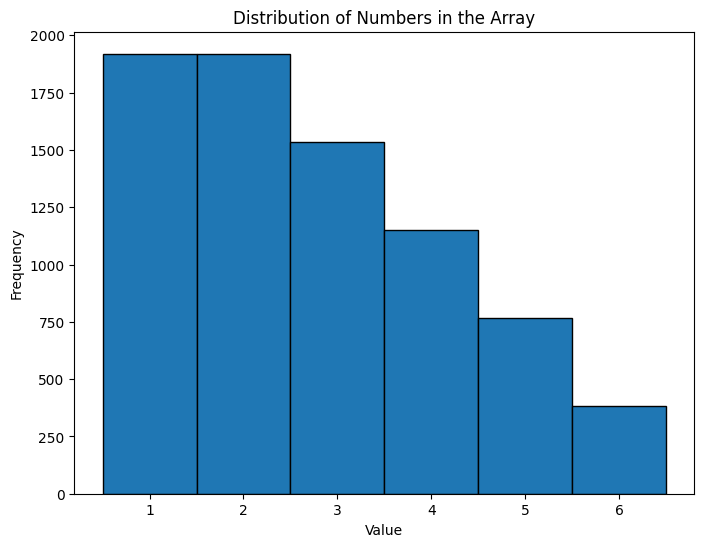

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Example array of integers
integer_array = labels

# Generate the bar chart for the distribution
plt.figure(figsize=(8, 6))
plt.hist(integer_array, bins=np.arange(min(integer_array), max(integer_array) + 2) - 0.5, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers in the Array')
plt.xticks(np.arange(min(integer_array), max(integer_array) + 1))

plt.show()

In [8]:
# Define input shapes
image_input_shape = (224, 224, 3)  # Example image size (224x224)

# Build the combined model
model = get_model(image_input_shape)

# Train the model
history = model.fit(
    image_data,  # Input data
    adjusted_labels,  # Target output (stable height)
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - loss: 6.3580 - mae: 1.6465 - val_loss: 11.0332 - val_mae: 1.6089
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - loss: 3.4972 - mae: 1.3582 - val_loss: 5.9951 - val_mae: 1.2808
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - loss: 3.0360 - mae: 1.2762 - val_loss: 4.9016 - val_mae: 1.2122
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - loss: 2.8417 - mae: 1.2082 - val_loss: 4.2117 - val_mae: 1.1757
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 642s 3s/step - loss: 2.5960 - mae: 1.1729 - val_loss: 4.0313 - val_mae: 1.1618
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - loss: 2.4131 - mae: 1.1104 - val_loss: 3.5671 - val_mae: 1.1426
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - loss: 2.2582 - mae: 1.0781 - val_loss: 4.2538 - val_mae: 1.1557
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - loss: 2.1792 - mae: 1.0499 - val_loss: 4.2975 - val_mae: 1.1565
Epoch 9/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 384s 2s

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


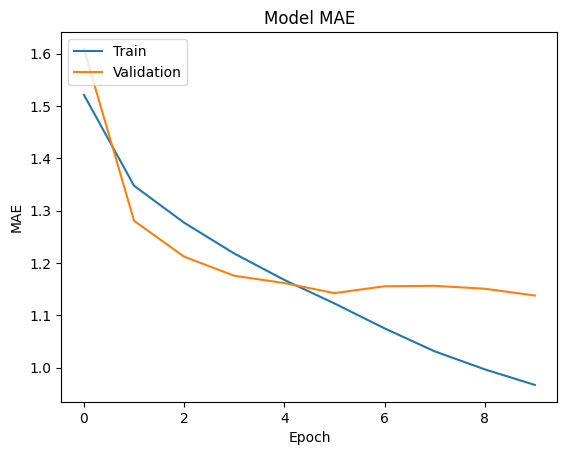

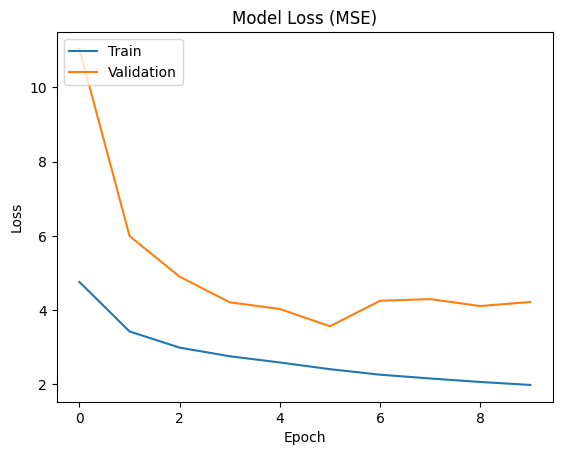

In [9]:
import matplotlib.pyplot as plt

print(history.history.keys())

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values (MSE)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [10]:
folder_path = '../COMP90086_2024_Project_test/test'
test = np.genfromtxt('../COMP90086_2024_Project_test/test.csv', delimiter=',', skip_header=1)
ids = np.array(test, dtype=int)
test_image_data = load_images_from_folder(folder_path, ids)

In [11]:
# Predict stable height on the test set
predicted_heights = model.predict(test_image_data)
adjusted_predicted_heights = predicted_heights + 1

60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step


In [12]:
import csv
with open('submission.csv', mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    submission_writer.writerow(['id', 'stable_height'])
    for i in range(len(ids)):
        submission_writer.writerow([ids[i], int(adjusted_predicted_heights[i][0])])